# Compare water phantom

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from copy import deepcopy

## Useful functions

In [2]:
def read_binary(filename, nx, ny, nz, t):
    with open(filename, 'rb') as infile:
        data = np.fromfile(infile, dtype=t)
    return data.reshape(nx, ny, nz)

def read_mhd(file):
    dirname = os.path.dirname(file)
    with open(file) as f:
        header = f.read().splitlines()
    for line in header:
        if 'DimSize' in line:
            _,_,nx,ny,nz = line.split()
        if 'ElementSpacing' in line:
            _,_,dx,dy,dz = line.split()
        if 'ElementDataFile' in line:
            _,_,binary = line.split()
        if 'ElementType' in line:
            _,_,temp_data_type = line.split()
    if temp_data_type == 'MET_FLOAT':
        data_type = np.float32
    return read_binary(os.path.join(dirname, binary), int(nx), int(ny), int(nz), data_type)

def read_mha(file):
    dirname = os.path.dirname(file)
    with open(file, "rb") as f:
        for _ in range(9):
            f.readline().decode('latin-1')
        _,_,dx,dy,dz = f.readline().decode('latin-1').split()
        _,_,nx,ny,nz = f.readline().decode('latin-1').split()
        _,_,temp_data_type = f.readline().decode('latin-1').split()
        f.readline().decode('latin-1')
        data_type = np.float32
        if temp_data_type == 'MET_UCHAR':
            data_type = np.dtype('B')
        
        data = np.fromfile(f, dtype=data_type)
    return data.reshape(int(nx), int(ny), int(nz))

def get_Bragg_peak(dose):
    sum1 = dose.sum(1)
    peak = np.squeeze(sum1.sum(1))
    return peak

def read_dd(filename, nx, ny, nz, t):
    with open(filename, 'rb') as infile:
        data = np.fromfile(infile, dtype=t)
    dd = get_Bragg_peak(data.reshape(nx, ny, nz))
    return dd

def read_ca(filename, nx, ny, nz, t):
    with open(filename, 'rb') as infile:
        data = np.fromfile(infile, dtype=t)
    data = data.reshape(nx, ny, nz)
    ca = data[:, ny//2, nz//2]
    return ca

def get_Bragg_peak_pos(dose):
    sum1 = dose.sum(1)
    sum2 = sum1.sum(1)
    return sum2.argmax()

def get_Bragg_peak_pos(dd):
    return dd.argmax()

def get_R80(dd, d = 1):
    pos = dd.argmax()
    BP = dd.max()
    idx = (np.abs(dd[pos+1:]-BP*0.8)).argmin()
    return (idx+pos)*d

def get_R80_dose(dd):
    BP = dd.max()
    return 0.8*BP

def get_R80s(dds, d = 1):
    ranges = list()
    for dd in dds:
        ranges.append(get_R80(dd, d))
    return ranges

def ratio(a, b, m = 0):
    if hasattr(a, '__len__'):
        res = list()
        for i in range(len(a)):
            v = a[i]/b[i] if b[i] > m else 1
            res.append(v)
        return np.array(res)
    else:
        return a/b if b > m else 1

def chess_mask(img, n, extent, shift=False):
    new = deepcopy(img)
    chess = np.array([[(i+j+shift)%2 for i in range(n)] for j in range(n)])
    di = (extent[1]-extent[0])/n
    dj = (extent[3]-extent[2])/n
    vec = []
    for j in range(img.shape[0]):
        for i in range(img.shape[1]):
            new[i,j] *= chess[int(i/di), int(j/dj)]
    return new

## Global constants

In [3]:
nx = 250; ny = 250; nz = 250;
dx = 2; dy = 2; dz = 2;
dims = np.array([nx, ny, nz])
cent_dims = dims // 2
pos = np.arange(0, 50, dx)

## Read data

In [4]:
orig = read_mhd('adaptation_0/0.mhd')
x20 = read_mhd('adaptation_x20/x20.mhd')
x10_y20_z30 = read_mhd('adaptation_x10_y20_z30/x10_y20_z30.mhd')
ref_x20 = read_mhd('additional_data/0_x20.mhd')
ref_x10_y20_z30 = read_mhd('additional_data/0_x10_y20_z30.mhd')
cube = read_mha('additional_data/reference_cube.mha')
cube_x20 = read_mha('additional_data/reference_cube_x20.mha')
cube_x10_y20_z30 = read_mha('additional_data/reference_cube_x10_y20_z30.mha')

## Get center of structure for all cases

[{'ave': [124.0, 124.5, 100.5], 'first': [94, 95, 86], 'last': [154, 154, 115]}, {'ave': [124.0, 124.5, 90.5], 'first': [94, 95, 76], 'last': [154, 154, 105]}, {'ave': [139.0, 134.5, 105.5], 'first': [109, 105, 91], 'last': [169, 164, 120]}]


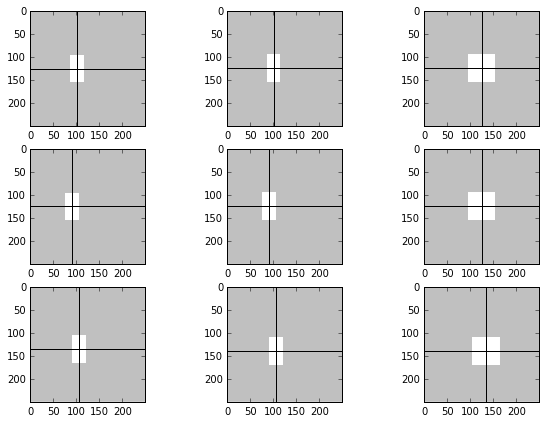

In [5]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 7)

centers = list()
for j, c in enumerate([cube, cube_x20, cube_x10_y20_z30]):
    tempave = list()
    lims1 = list()
    lims2 = list()
    for i, idx in enumerate(['x', 'y', 'z']):
        if idx == 'x': idx0 = 1; idx1 = 1;
        if idx == 'y': idx0 = 2; idx1 = 0;
        if idx == 'z': idx0 = 0; idx1 = 0;
        temp = c.sum(idx0).sum(idx1)
        temp = np.squeeze(np.where(temp>0.5))
        lims1.append(temp[0])
        lims2.append(temp[-1])
        tempave.append((temp[0]+temp[-1])/2)
    centers.append({'first': lims1, 'ave': tempave, 'last': lims2})
print(centers)

fig = plt.figure()
for j, c in enumerate([cube, cube_x20, cube_x10_y20_z30]):
    for i in range(3):
        s0 = slice(c.shape[0]) if i != 0 else int(centers[j]['ave'][i])
        s1 = slice(c.shape[1]) if i != 1 else int(centers[j]['ave'][i])
        s2 = slice(c.shape[2]) if i != 2 else int(centers[j]['ave'][i])
        if i == 0:   lh = centers[j]['ave'][1]; lv = centers[j]['ave'][2]
        elif i == 1: lh = centers[j]['ave'][0]; lv = centers[j]['ave'][2]
        else:        lh = centers[j]['ave'][0]; lv = centers[j]['ave'][1]
        ax = fig.add_subplot(3, 3, (i+1)+3*(j%3))
        ax.imshow(c[s0, s1, s2], cmap=plt.cm.gray, alpha=0.25, interpolation='None')
        ax.axvline(lv, color='k')
        ax.axhline(lh, color='k')

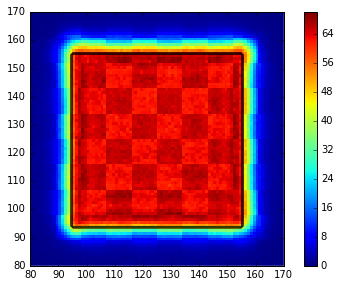

In [6]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 10)

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
xmin = 80; xmax = 170
ymin = 80; ymax = 170
extent = (xmin, xmax, ymin, ymax)
img1 = chess_mask(orig[xmin:xmax, ymin:ymax, 100], 10, extent)
img2 = chess_mask(x20[xmin:xmax, ymin:ymax, 80], 10, extent, shift=True)
thisplot = ax.imshow(img1+img2, extent=extent, interpolation='None', vmin=0, vmax=70)
ax.contour(cube[xmin:xmax, ymin:ymax, 100], linewidths=0.5, colors='k', extent=extent)
plt.colorbar(thisplot)

## Single slice profiles thourgh centers

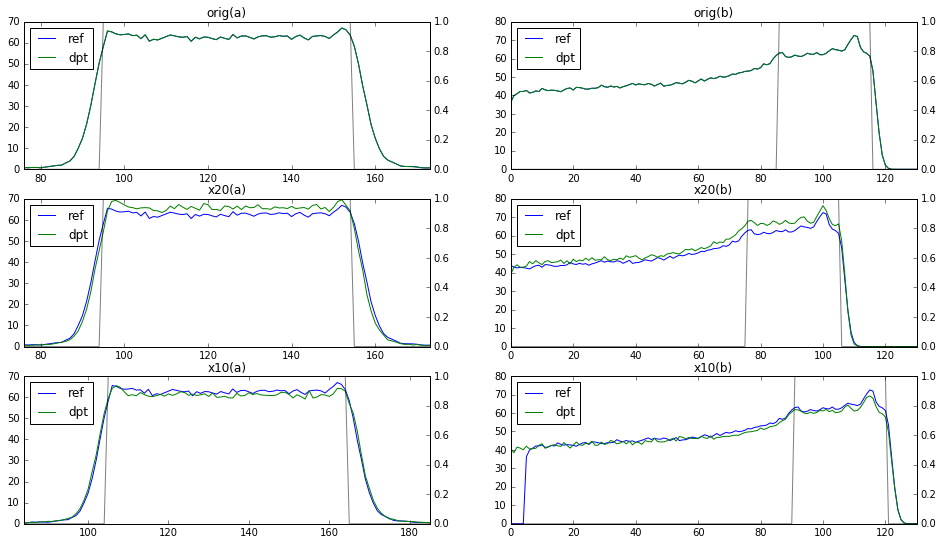

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 9)

fig = plt.figure()
cases = ['orig(a)', 'orig(b)', 'x20(a)', 'x20(b)', 'x10(a)', 'x10(b)']
for j, vols in enumerate([[orig, orig, cube], [x20, ref_x20, cube_x20],
                          [x10_y20_z30, ref_x10_y20_z30, cube_x10_y20_z30]]):
    for i, axis_idx in enumerate([1, 2]):
        if axis_idx == 1:
            a = int(centers[j]['ave'][0])
            b = slice(vols[0].shape[1])
            c = int(centers[j]['ave'][2])
        else:
            a = int(centers[j]['ave'][0])
            b = int(centers[j]['ave'][1])
            c = slice(vols[0].shape[2])        
        ax = fig.add_subplot(3, 2, axis_idx+2*j)
        ax.set_title(cases[i+2*j])
        ax2 = ax.twinx()
        ax2.plot(vols[2][a, b, c], alpha=0.5, color='black')
        ax.plot(vols[1][a, b, c], alpha=1, label='ref')
        ax.plot(vols[0][a, b, c], alpha=1, label='dpt')
        margin = 0.2*centers[j]['first'][axis_idx]
        ax.set_xlim((axis_idx != 2)*(centers[j]['first'][axis_idx]-margin),
                    (axis_idx != 2)*(centers[j]['last'][axis_idx]+margin) + (axis_idx == 2)*130)
        ax.legend(loc='upper left')


## Integrated centers (10 slices)

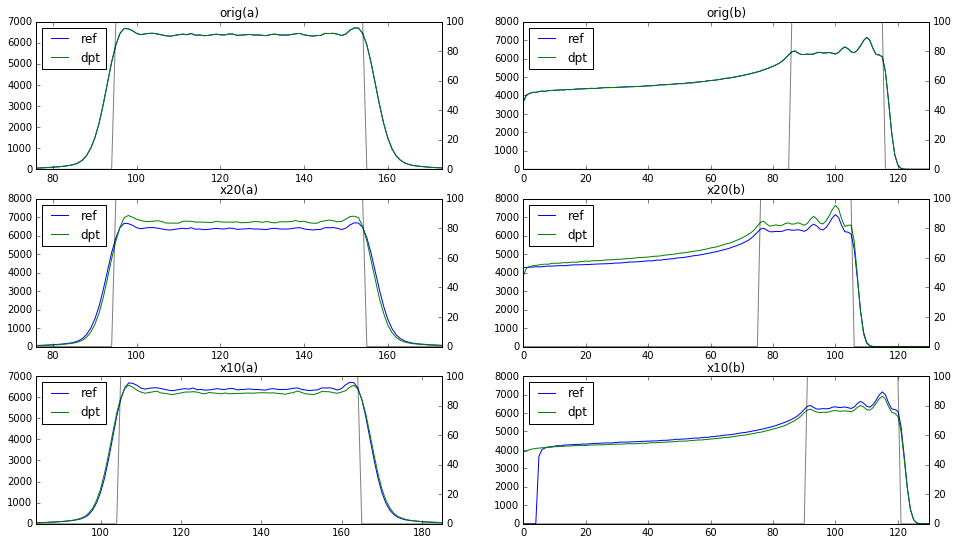

In [9]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 9)

fig = plt.figure()
cases = ['orig(a)', 'orig(b)', 'x20(a)', 'x20(b)', 'x10(a)', 'x10(b)']
for j, vols in enumerate([[orig, orig, cube], [x20, ref_x20, cube_x20],
                          [x10_y20_z30, ref_x10_y20_z30, cube_x10_y20_z30]]):
    for i, axis_idx in enumerate([1, 2]):
        if axis_idx == 1:
            a = slice(int(centers[j]['ave'][0]-5), int(centers[j]['ave'][0]+5))
            b = slice(vols[0].shape[1])
            c = slice(int(centers[j]['ave'][2]-5), int(centers[j]['ave'][2]+5))
            temp_vol0 = vols[0][a, b, c].sum(0).sum(1)
            temp_vol1 = vols[1][a, b, c].sum(0).sum(1)
            temp_vol2 = vols[2][a, b, c].sum(0).sum(1)
        else:
            a = slice(int(centers[j]['ave'][0]-5), int(centers[j]['ave'][0]+5))
            b = slice(int(centers[j]['ave'][1]-5), int(centers[j]['ave'][1]+5))
            c = slice(vols[0].shape[2])
            temp_vol0 = vols[0][a, b, c].sum(0).sum(0)
            temp_vol1 = vols[1][a, b, c].sum(0).sum(0)
            temp_vol2 = vols[2][a, b, c].sum(0).sum(0)
        
        ax = fig.add_subplot(3, 2, axis_idx+2*j)
        ax.set_title(cases[i+2*j])
        ax2 = ax.twinx()
        ax2.plot(temp_vol2, alpha=0.5, color='black')
        ax.plot(temp_vol1, alpha=1, label='ref')
        ax.plot(temp_vol0, alpha=1, label='dpt')
        margin = 0.2*centers[j]['first'][axis_idx]
        ax.set_xlim((axis_idx != 2)*(centers[j]['first'][axis_idx]-margin),
                    (axis_idx != 2)*(centers[j]['last'][axis_idx]+margin) + (axis_idx == 2)*130)
        ax.legend(loc='upper left')


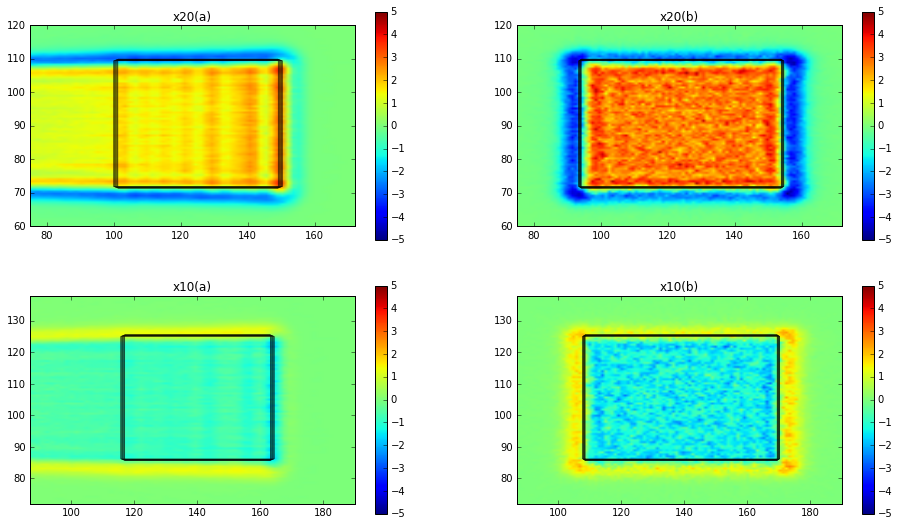

In [11]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 9)

fig = plt.figure()
cases = ['x20(a)', 'x20(b)', 'x10(a)', 'x10(b)']
for j, vols in enumerate([[x20, ref_x20, cube_x20],
                          [x10_y20_z30, ref_x10_y20_z30, cube_x10_y20_z30]]):
    amargin = 0.2*centers[j+1]['first'][0]
    bmargin = 0.2*centers[j+1]['first'][1]
    cmargin = 0.2*centers[j+1]['first'][2]
    amin = int(centers[j+1]['first'][0]-amargin); amax = int(centers[j+1]['last'][0]+amargin)
    bmin = int(centers[j+1]['first'][1]-bmargin); bmax = int(centers[j+1]['last'][1]+bmargin)
    cmin = int(centers[j+1]['first'][2]-cmargin); cmax = int(centers[j+1]['last'][2]+cmargin)
    extent = (amin, amax, cmin, cmax)
    adaptive_  = vols[0][slice(amin, amax), slice(bmin, bmax), slice(cmin, cmax)]
    reference_ = vols[1][slice(amin, amax), slice(bmin, bmax), slice(cmin, cmax)]
    temp_vol2_ = vols[2][slice(amin, amax), slice(bmin, bmax), slice(cmin, cmax)]
    
    for i, axis_idx in enumerate([1, 2]):
        nlices = adaptive_.shape[axis_idx]
        adaptive = adaptive_.sum(axis_idx)
        reference = reference_.sum(axis_idx)
        temp_vol2 = temp_vol2_.sum(axis_idx)
        
        ax = fig.add_subplot(2, 2, axis_idx+2*j)
        diff = np.squeeze(adaptive-reference)/nlices
        ax.set_title(cases[i+2*j])
        thisplot = ax.imshow(diff, extent=extent, vmin=-5, vmax=5)
        ax.contour(temp_vol2, colors='k', linewidths=0.5, extent=extent)
        plt.colorbar(thisplot)
